In [52]:
import pandas as pd
import numpy as np

from IPython.display import display

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
pd.set_option('display.width', 15000)
pd.set_option('display.max_columns', 100)
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context('poster')
%matplotlib inline

In [2]:
raw_dir = 'raw/'
df_business = pd.read_csv(raw_dir + 'business.csv')
df_review = pd.read_csv(raw_dir + 'review.csv')
df_user = pd.read_csv(raw_dir + 'user.csv')
data_review = df_review[['user_id', 'business_id', 'stars']]

In [3]:
print('The number of missing values in review.stars is {}.'.format(np.sum(data_review.stars.isnull())))

The number of missing values in review.stars is 0.


In [4]:
# check duplicates

data_review.groupby(['user_id', 'business_id']).count()\
[data_review.groupby(['user_id', 'business_id']).count() != 1].dropna()

,,stars
user_id,business_id,
XNzChtoNOw706kps82x0Kg,xKQVtEWiPK6hq0DljVnAfg,2.0


In [5]:
df_review.query('user_id == "XNzChtoNOw706kps82x0Kg" & business_id == "xKQVtEWiPK6hq0DljVnAfg"')

,funny,user_id,review_id,text,business_id,stars,date,useful,cool
4291340,0,XNzChtoNOw706kps82x0Kg,1l-mU-BwQsZRW7BKdHVwZw,"This place continues to be a shit hole, with P...",xKQVtEWiPK6hq0DljVnAfg,1,2017-05-02,0,0
4291341,0,XNzChtoNOw706kps82x0Kg,IcpPtd37iJEthZybuasS4g,My mother recently spent a good deal of time i...,xKQVtEWiPK6hq0DljVnAfg,1,2015-02-06,9,0


As we can see, there is only one case where a user rate the same restaurant more than once and the ratings are the same in this case, indicating we don't need to take care of the corner case of duplicates for this dataset.

In [15]:
df_business[['city', 'name']].groupby('city', as_index=False).count().sort_values(by='name', ascending=False)

,city,name
395,Las Vegas,24768
655,Phoenix,15656
908,Toronto,15483
135,Charlotte,7557
805,Scottsdale,7510
674,Pittsburgh,5688
525,Montréal,5175
490,Mesa,5146
316,Henderson,4130
899,Tempe,3949


In [121]:
def get_city(city, df_business=df_business, df_review=df_review):
    dfb = df_business[df_business['city'] == city]
    dfr = pd.merge(dfb[['business_id']], df_review, how='inner', on='business_id')
    return dfb, dfr

def get_count(dfr):
    return dfr.groupby('business_id', as_index=False).count()['stars'], \
dfr.groupby('user_id', as_index=False).count()['stars']

def plot_star_hist(dfr):
    x = list(range(1, 6))
    y = np.bincount(dfr['stars'], minlength=6)[1:]
    plt.bar(x, y, width=0.5)

In [123]:
dfb, dfr = get_city('Mt Albert')

In [125]:
bus_count, user_count = get_count(dfr)

In [127]:
np.sum(user_count > 0)

9

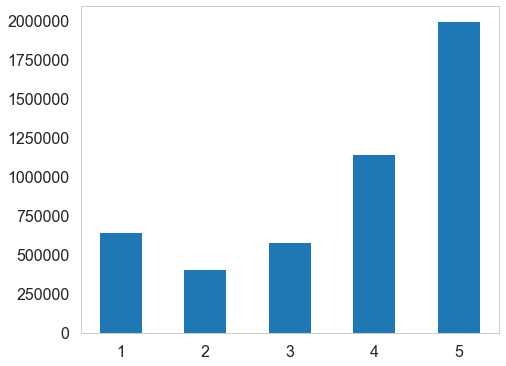

In [122]:
plt.figure(figsize=(7.5, 6))
plot_star_hist(df_review)

array([   0, 1193,  809, 1296, 2400, 2427], dtype=int64)